<a href="https://colab.research.google.com/github/davidbau/unlearnable/blob/main/Learnable_and_Unlearnable_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple synthetic data that can be learned (or not) by a simple deep network.

Deep networks have an inductive bias that allows them to generalize certain types of synthetic data.  What is that inductive bias?

We begin by generating a few synthetic data sets using the same type of hierarchical data generation function.  Each data set consists of a set of short bitmaps as input (around 30-40 bits), divided into two classes.  The task of the model will be to learn the classification rule and generalize to held-out examples.

In [1]:
import torch
import numpy
import torch.nn as nn
import torch.optim as optim
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
import sys
from google.colab import output

# The data-generating function
class SumComparison:
    def __init__(self, *ops):
        self.ops = ops
        self.data_width = int(numpy.prod([group * 2 for group, op in ops]))
    def __call__(self, x):
        for group, op in self.ops:
            counts = [x[i:i+group].sum() for i in range(0, len(x), group)]
            x = torch.stack([op(counts[i], counts[i+1]).float() for i in range(0, len(counts), 2)])
        return x

# Balanced Data Generation Function
def nested_count_data(num_samples=2000, operation=SumComparison((1, torch.eq)), seed=1, balance=True):
    make_samples = num_samples
    while True:
        if balance:
            make_samples = make_samples * 2
        data_width = operation.data_width
        prng = numpy.random.RandomState(seed)
        data = torch.from_numpy(
            prng.randint(0, 2, make_samples * data_width)).view(make_samples, data_width)
        count = [0, 0]
        filtered = []
        for sample in data:
            label = int(operation(sample))
            count[label] += 1
            if not balance or count[label] <= -(-num_samples // 2):
                filtered.append((sample, torch.tensor(label)))
        if len(filtered) < num_samples:
            continue
        prng.shuffle(filtered)
        return [torch.stack(d) for d in zip(*filtered)]

# Generate data
def make_data_set(operation):
    train_data, train_labels = nested_count_data(operation=operation, num_samples=8000, seed=4)
    test_data, test_labels = nested_count_data(operation=operation, num_samples=1000, seed=5)
    val_data, val_labels = nested_count_data(operation=operation, num_samples=1000, seed=6)
    return (train_data, train_labels, test_data, test_labels, val_data, val_labels)
    # print(f'{(train_data[:,None,:] == test_data[None, :, :]).prod(axis=1).sum().item()} overlap between train and test.')
    # print(f'{(train_data[:,None,:] == val_data[None, :, :]).prod(axis=1).sum().item()} overlap between train and val.')
    # print(f'{(test_data[:,None,:] == val_data[None, :, :]).prod(axis=1).sum().item()} overlap between test and val.')
    # print(f'Data width {operation.data_width}; Constant baseline accuracy {max(test_labels.sum(), len(test_labels) - test_labels.sum()) / len(test_labels):.3f}')

parity_data = make_data_set(SumComparison((1, torch.eq), (1, torch.eq),
    (1, torch.eq), (1, torch.eq), (1, torch.eq)))

skewed_data = make_data_set(SumComparison((1, torch.eq),
    (1, torch.lt), (1, torch.lt), (1, torch.lt),
    (1, torch.eq)))

# Learnable data:
learnable_data = make_data_set(SumComparison((3, torch.lt), (3, torch.eq)))

# Unlearnable data
unlearnable_data = make_data_set(SumComparison((3, torch.eq), (3, torch.eq)))

# Deep network training

Now we define a simple framework for training a binary classifier to solve the problem.  Below we include a couple examples of network architectures and optimization configurations that can solve many real-world problems.

Those configurations can learn to generalize some of the data, but not other data.  What makes some of the data more learnable than others?

In [2]:
class Constant(Module):
    def __init__(self, c):
        super().__init__()
        self.c = c
    def forward(self, x):
        return self.c[None].repeat(x.size(0), *[1 for _ in self.c.shape])

class ResidualSequence(Sequential):
    def forward(self, x):
        side_result = super().forward(x)
        return x + side_result

class Supervise(Module):
    def __init__(self, criterion, net):
        super().__init__()
        self.net = net
        self.criterion = criterion
    def forward(self, x, y):
        out = self.net(x).squeeze()
        return self.criterion(out, y)

def run_test(data, net, optmaker, test_every=10):
    # get data
    train_data, train_labels, test_data, test_labels = data[:4]
    # Set up the Loss Function and Optimizer
    optimizer = optmaker(net.parameters())
    print(f'{sum([p.numel() for p in net.parameters()])} parameters')
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(2000):
        optimizer.zero_grad()
        loss = net(train_data.float(), train_labels.float())
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), 0.1)
        train_losses.append([epoch, loss.item()])
        optimizer.step()
        if epoch % test_every == test_every - 1:
            grads = torch.stack([p.grad.abs().max() for p in net.parameters()])
            maxg, ming = grads.abs().max(), grads.abs().min()
            train_outputs = net.net(train_data.float())
            train_preds = (train_outputs.squeeze() > 0.5).float()
            train_accuracy = (train_preds == train_labels).float().mean()
            train_accs.append([epoch + 1, train_accuracy])
            test_outputs = net.net(test_data.float())
            test_preds = (test_outputs.squeeze() > 0.5).float()
            test_accuracy = (test_preds == test_labels).float().mean()
            test_accs.append([epoch + 1, test_accuracy])
            output.clear(output_tags='status', wait=True)
            with output.use_tags('status'):
                sys.stdout.write(
                    f'Epoch {epoch+1}, Loss: {loss.item():.5f}, Grad range {maxg:.1e} to {ming:.1e}, '
                    f'Train Accuracy: {train_accuracy.item()}, Test Accuracy: {test_accuracy.item():.5f}\n')
                sys.stdout.flush()
            if test_accuracy.item() == 1.0:
                break

    # Test the Model
    with torch.no_grad():
        train_outputs = net.net(train_data.float())
        train_preds = (train_outputs.squeeze() > 0.5).float()
        train_accuracy = (train_preds == train_labels).float().mean()
        test_outputs = net.net(test_data.float())
        test_preds = (test_outputs.squeeze() > 0.5).float()
        test_accuracy = (test_preds == test_labels).float().mean()
        print(f'\nTrain Accuracy: {train_accuracy.item()}, Test Accuracy: {test_accuracy.item()}')
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(*zip(*train_losses), label="Training loss")
    ax.set_yscale('log')
    ax2.plot(*zip(*train_accs), color="orange", label="Training accuracy")
    ax2.plot(*zip(*test_accs), color="red", label="Test accuracy")
    ax2.set_ylim(0.0, 1.0)
    for a in [ax, ax2]:
        for pos in 'top right bottom left'.split():
            a.spines[pos].set_visible(False)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    fig.legend(loc="lower left", bbox_to_anchor=(0, 0), bbox_transform=ax.transAxes)
    fig.show()

# Learnable data

First we learn to generalize some learnable data.

21377 parameters


Epoch 2000, Loss: 0.06551, Grad range 7.7e-03 to 1.4e-03, Train Accuracy: 0.9363750219345093, Test Accuracy: 0.91700



Train Accuracy: 0.9363750219345093, Test Accuracy: 0.9169999957084656


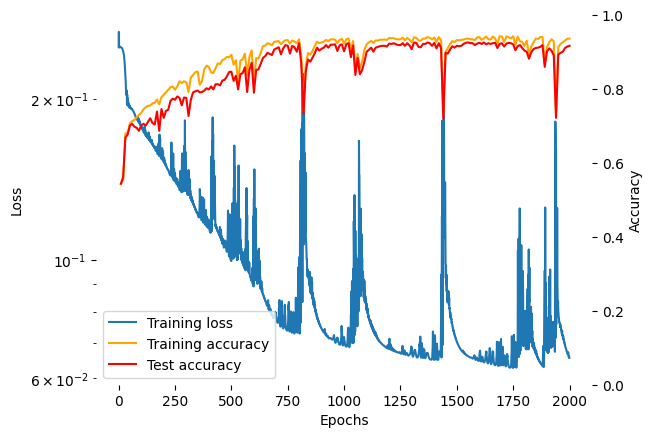

In [4]:
# A very ordinary neural network
hidden_dims = 128
run_test(
    learnable_data,
    Supervise(
        nn.MSELoss(),
        nn.Sequential(
            # Erase this and have the student create it.
            nn.Linear(learnable_data[0].size(1), hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, 1),
            nn.Sigmoid()
        )
    ),
    lambda p: optim.Adam(p, lr=0.01, weight_decay=1e-3),
)

14049 parameters


Epoch 440, Loss: 0.00170, Grad range 1.5e-03 to 7.8e-10, Train Accuracy: 1.0, Test Accuracy: 1.00000



Train Accuracy: 1.0, Test Accuracy: 1.0


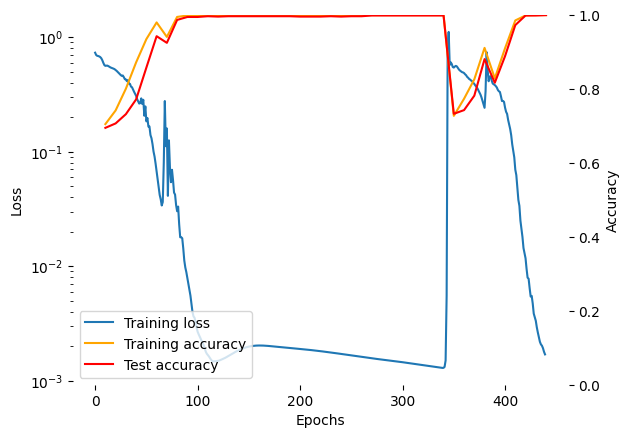

In [5]:
# Using BatchNorm and Residuals simultaneously helps a lot
hidden_dims = 32
fan_out_dims = 64
run_test(
    learnable_data,
    Supervise(
        nn.BCELoss(),
        torch.nn.Sequential(
            nn.Linear(learnable_data[0].size(1), hidden_dims),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, 1),
            nn.Sigmoid()
        )
    ),
    lambda p: optim.Adam(p, lr=0.01, weight_decay=1e-3),
)

# Unlearnable data

The following data is very similar, but unlearnable.

The difference is not due to a difference in expressiveness in the neural network.  For example, if you pretrain on the learnable data, then you will be able to train a neural network that perfectly generalizes the unlearnable data

21377 parameters


Epoch 2000, Loss: 0.18759, Grad range 1.5e-03 to 2.1e-04, Train Accuracy: 0.7291250228881836, Test Accuracy: 0.51800



Train Accuracy: 0.7291250228881836, Test Accuracy: 0.5180000066757202


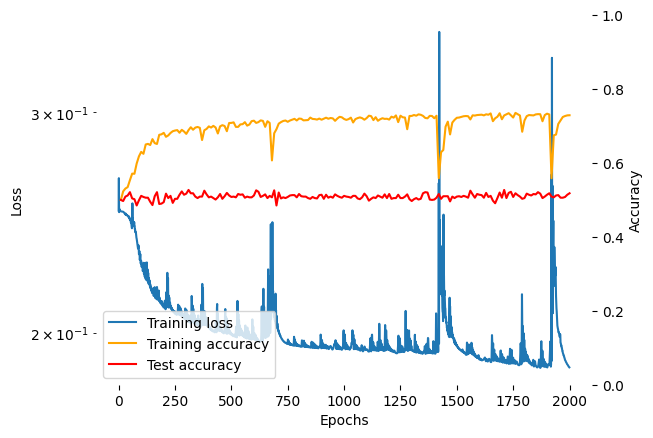

In [6]:
# A very ordinary neural network
hidden_dims = 128
run_test(
    unlearnable_data,
    Supervise(
        nn.MSELoss(),
        nn.Sequential(
            # Erase this and have the student create it.
            nn.Linear(unlearnable_data[0].size(1), hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, 1),
            nn.Sigmoid()
        )
    ),
    lambda p: optim.Adam(p, lr=0.01, weight_decay=1e-3),
)

In [ ]:
# Using BatchNorm and Residuals simultaneously helps a lot
hidden_dims = 32
fan_out_dims = 64
run_test(
    unlearnable_data,
    Supervise(
        nn.BCELoss(),
        torch.nn.Sequential(
            nn.Linear(unlearnable_data[0].size(1), hidden_dims),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, 1),
            nn.Sigmoid()
        )
    ),
    lambda p: optim.Adam(p, lr=0.01, weight_decay=1e-3),
)

14049 parameters


Epoch 440, Loss: 0.67898, Grad range 2.5e-03 to 2.8e-09, Train Accuracy: 0.575124979019165, Test Accuracy: 0.49900
